In [0]:
import numpy as np
import pandas as pd
# import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os, glob, math
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import json
from google.colab import drive

In [2]:
drive.mount(os.path.join('/content', 'drive'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PROJECT_PATH = os.path.join('/content', 'drive', 'My Drive',
                             'Hacktiv8', 'projData')

In [4]:
import tensorflow as tf
import os
if not (tf.__version__).startswith('2.1'):
    !pip install -q -U tensorflow
else: print (f"TF v: {tf.__version__}")

if not os.path.exists(os.path.join('cats_dogs', 'train')):
    !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
    !unzip -q cats_and_dogs_filtered.zip
    !mv cats_and_dogs_filtered cats_dogs
    !ls cats_dogs | head

TF v: 2.1.0



0. Data Analysis

We first need to check whether the data are consistent, in terms of image dimension.

In [0]:
train_width, train_height = [], []
train_channel = set()
test_width, test_height = [], []
test_channel = set()

In [0]:
for animal in ['dogs', 'cats']:
    animaux = animal[:-1]
    for fname in glob.glob(os.path.join('cats_dogs', 'train', animal, f'{animaux}*.jpg')):
        im = Image.open(fname)
        w, h = im.size
        train_width.append(w)
        train_height.append(h)
        train_channel.add(im.getbands())
    for fname in glob.glob(os.path.join('cats_dogs', 'validation', animal, f'{animaux}*.jpg')):
        im = Image.open(fname)
        w, h = im.size
        test_width.append(w)
        test_height.append(h)
        test_channel.add(im.getbands())

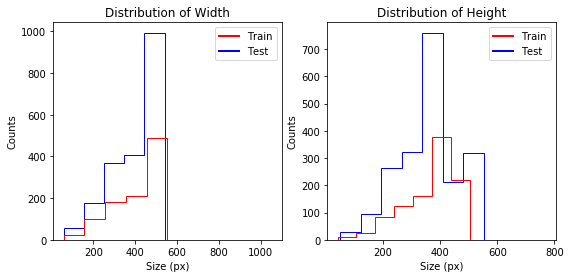

In [7]:
fig = plt.figure(figsize=(9, 4))
from matplotlib.lines import Line2D
custom_lines = [Line2D([1], [1], color='red', lw=2),
                Line2D([1], [1], color='blue', lw=2)]
plt.subplot(1, 2, 1)
plt.title('Distribution of Width')
plt.xlabel('Size (px)')
plt.ylabel('Counts')
plt.hist(train_width, label='trainWidth', color='blue', histtype='step')
plt.hist(test_width, label='testWidth', color='red', histtype='step')
plt.legend(custom_lines, ['Train', 'Test'])
plt.subplot(1, 2, 2)
plt.title('Distribution of Height')
plt.xlabel('Size (px)')
plt.ylabel('Counts')
plt.hist(train_height, label='trainHeight', color='blue', histtype='step')
plt.hist(test_height, label='testHeight', color='red', histtype='step')
plt.legend(custom_lines, ['Train', 'Test'])
plt.show()

In [8]:
df_dist = pd.DataFrame(index=['MedianWidth', 'MedianHeight'])
from fractions import Fraction
df_dist['Train'] = pd.Series({'MedianWidth': np.median(train_width),
                              'MedianHeight': np.median(train_height)})
df_dist['Test'] = pd.Series({'MedianWidth': np.median(test_width),
                              'MedianHeight': np.median(test_height)})
df_dist['Average'] = df_dist.mean(axis=1)
df_dist = df_dist.astype(int)
display (df_dist)

,Train,Test,Average
MedianWidth,442,448,445
MedianHeight,374,374,374


In [9]:
train_channel, test_channel

({('R', 'G', 'B')}, {('R', 'G', 'B')})



1. Model Initialisation & Training

We know that the colour channels are concordant between the datasets, i.e. RGB, so we can hardcode it appropriately during data loading. Also, due to the distribution of the dataset dimensions, let's take and rescale to the average of the median values.


In [10]:
BATCH_SIZE = 32
AVG_MED_WIDTH = 192#int(df_dist.loc['MedianWidth', 'Average']/4)
AVG_MED_HEIGHT = 192#int(df_dist.loc['MedianHeight', 'Average']/4)
print (f'AVG MED WIDTH {AVG_MED_WIDTH}')
print (f'AVG MED HEIGHT {AVG_MED_HEIGHT}')
INPUT_SIZE = (AVG_MED_HEIGHT, AVG_MED_WIDTH)

AVG MED WIDTH 192
AVG MED HEIGHT 192


In [11]:
print ("Getting Training Data")
trainGenerator = ImageDataGenerator(
                rescale=1./255, 
                rotation_range=30,
                zoom_range=0.15,
                width_shift_range=0.15, 
                height_shift_range=0.15, 
                horizontal_flip=True,
#                 vertical_flip=True,
                validation_split=0.0
                )

print ("Subsampling Validation Set")
validation_data = trainGenerator.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('cats_dogs', 'train'),
                    target_size=INPUT_SIZE,
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'],
                    subset='validation')

print ("Subsampling Training Set")
train_data = trainGenerator.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('cats_dogs', 'train'),
                    target_size=INPUT_SIZE,
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'],
                    subset='training')

print ("Test Data")
test_data = ImageDataGenerator(
                rescale=1./255
                ).flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('cats_dogs', 'validation'),
                    target_size=INPUT_SIZE,
                    color_mode='rgb',
                    class_mode='binary',
                    classes=['cats', 'dogs'])

Getting Training Data
Subsampling Validation Set
Found 0 images belonging to 2 classes.
Subsampling Training Set
Found 2000 images belonging to 2 classes.
Test Data
Found 1000 images belonging to 2 classes.


In [12]:
sample_train, label = next(train_data)
num_train_data = train_data.n
num_val_data = validation_data.n
num_test_data = test_data.n
print (num_train_data)

2000


In [0]:
labelName = {0.:'catto', 1.:'doggo'}

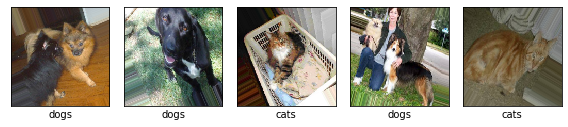

In [14]:
def plotImages(images_arr, label_arr):
    fig, axes = plt.subplots(1, 5, figsize=(8,8))
    axes = axes.flatten()
    for img, dataLabel, ax in zip(images_arr, label_arr, axes):
        ax.imshow(img)
        ax.set_xlabel(labelName[dataLabel])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.tight_layout()
    plt.show()

plotImages(sample_train[:5], label[:5])

In [27]:
epochs = 75
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_uniform',
                           input_shape=(AVG_MED_HEIGHT, AVG_MED_WIDTH, 3)),
    MaxPooling2D(2, strides=2),
    Dropout(0.1),

    # Conv2D(32, 3, padding='same', activation='relu'),    
    # MaxPooling2D(2, strides=2),
    # Dropout(0.1, seed=111), 

    Conv2D(64, 3, padding='same', activation='relu'),    
    MaxPooling2D(2, strides=2),
    Dropout(0.1, seed=111),  

    Conv2D(128, 3, padding='same', activation='relu'),    
    MaxPooling2D(2, strides=2),
    Dropout(0.1, seed=111),  

    Conv2D(256, 3, padding='same', activation='relu'),    
    MaxPooling2D(2, strides=2),
    Dropout(0.1, seed=111), 

    Conv2D(512, 3, padding='same', activation='relu'),    
    MaxPooling2D(2, strides=2),
    Dropout(0.1, seed=111), 

    Flatten(),
    Dense(2048, activation='relu'),
    Dense(1, activation='sigmoid')
    ])
model.compile(optimizer=optimizers.Adam(epsilon=1e-4),#learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
model.summary()
now = datetime.strftime(datetime.today(), '%Y%m%d_%H%M')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 192, 192, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 96, 96, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 128)      

In [0]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10,
                                              verbose=1)

LR_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=5, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=1e-5)
callbacks = [early_stop, LR_reduce]

In [29]:
history = model.fit(train_data, 
                    steps_per_epoch=math.ceil(num_train_data/BATCH_SIZE), 
                    epochs=epochs,
                    validation_data=test_data,
                    callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 63 steps, validate for 32 steps
Epoch 1/75
63/63 [==============================] - 26s 411ms/step - loss: 0.7491 - accuracy: 0.4890 - AUC: 0.4916 - Precision: 0.4912 - Recall: 0.6170 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_AUC: 0.4340 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 2/75
63/63 [==============================] - 24s 383ms/step - loss: 0.6933 - accuracy: 0.5015 - AUC: 0.5008 - Precision: 0.5016 - Recall: 0.4760 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_AUC: 0.4900 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00
Epoch 3/75
63/63 [==============================] - 24s 385ms/step - loss: 0.6933 - accuracy: 0.5000 - AUC: 0.5086 - Precision: 0.5000 - Recall: 0.2050 - val_loss: 0.6925 - val_accuracy: 0.5020 - val_AUC: 0.5437 - val_Precision: 0.7500 - val_Recall: 0.0060
Epoch 4/75
63/63 [==============================] - 24s 384ms/step - loss: 0.6932 - accuracy: 0.5085 - AUC: 0.5237 - Prec

20200214_1624


True

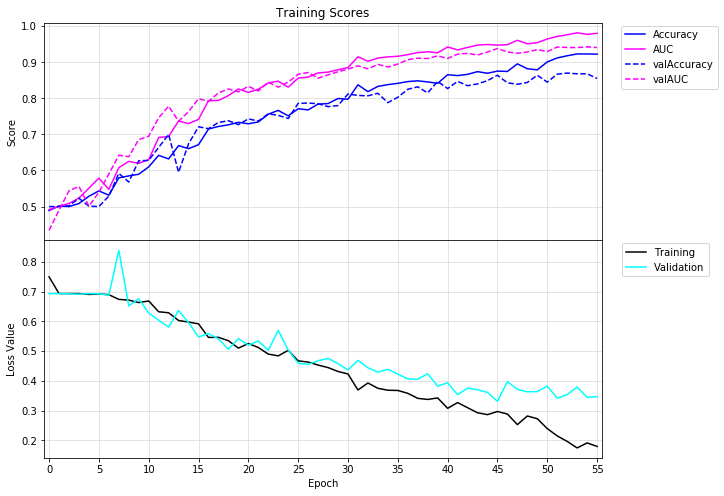

In [34]:
def plotHistory(history, n=''):
    try:
        # if 'acc' in history.history: 
        fig = plt.figure(figsize=(10, 8))
        plt.subplot(2, 1, 1)
        # n = 'f_{n}'
        n = f'{n}'
        minVal, maxVal = 1, 0
        finalEpoch = len(history.history['accuracy'])
        for result in history.history:
            if 'loss' not in result:
                for val in history.history[result]:
                    if val < minVal: minVal = val
                    if val > maxVal: maxVal = val
        # plt.tight_layout()
        plt.title('Training Scores')
        plt.plot(history.history['accuracy'], 
                 color='blue', label='Accuracy')
        # plt.plot(history.history[f'precision{n}'], color='red', label='Precision')
        # plt.plot(history.history[f'Recall{n}'], color='green', label='Recall')
        plt.plot(history.history[f'AUC{n}'], 
                 color='magenta', label='AUC')
        plt.plot(history.history['val_accuracy'], '--', 
                 color='blue', label='valAccuracy')
        # plt.plot(history.history[f'val_precision{n}'], '--', color='red', label='valPrecision')
        # plt.plot(history.history[f'val_recall{n}'], '--', color='green', label='valRecall')
        plt.plot(history.history[f'val_AUC{n}'], '--', 
                 color='magenta', label='valAUC')
        plt.xticks(range(0, finalEpoch, 5))
        plt.xlim((-0.5, finalEpoch-0.5))
        # plt.yticks(np.arange(round(minVal, 1)-0.05, round(maxVal, 1)+0.05, 0.05))
        # plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.grid(color='#DDDDDD')
        plt.tick_params(axis='x', labelcolor='#FFFFFF')
        plt.legend(bbox_to_anchor=(1.025, 1.01))
        plt.subplots_adjust(hspace=0.001)

        plt.subplot(2, 1, 2)
        # plt.title('Loss')
        plt.ylabel('Loss Value')
        plt.xlabel('Epoch')
        plt.xticks(range(0, finalEpoch, 5))
        plt.xlim((-0.5, finalEpoch-0.5))
        plt.plot(history.history['loss'], 
                 color='black', label='Training')
        plt.plot(history.history['val_loss'], 
                 color='cyan', label='Validation')
        plt.grid(color='#DDDDDD')
        plt.legend(bbox_to_anchor=(1.2, 1.01))
        plt.subplots_adjust(hspace=0.001)
        
        plt.savefig(os.path.join(PROJECT_PATH, f'{now}.png'))#, bbox_inches='tight')
        return True
    except Exception as E:
        print ('Unable to produce figure:', E) 
        return False

print (now)
plotHistory(history, '')

In [31]:
def saveModel(history):
    print ("Saving model configuration and training stats...")
    try:
        df = pd.DataFrame.from_dict(history.history)
        df.to_json(os.path.join(PROJECT_PATH, f'history_{now}.json'))
    except Exception as E:
        print ('Unable to save history!')
        pass
    with open(os.path.join(PROJECT_PATH, f'{now}.json'), 'wt') as inj:
        json.dump(history.model.to_json(), inj)
    with open(os.path.join(PROJECT_PATH, f'ImgDatGen_{now}.json'), 'wt') as inj:
        tempJson = json.dumps(vars(trainGenerator))
        json.dump(tempJson, inj)
    plt.show()
    model.save(os.path.join(PROJECT_PATH, f'model_{now}.h5'))
    print ("Model saved.")
    return True

saveModel(history)

Saving model configuration and training stats...
Model saved.


True

In [35]:
print ("Accuracy", history.history['accuracy'][-1])
print ("ValAccuracy", history.history['val_accuracy'][-1])
print ("AUC", history.history['AUC'][-1])
print ("valAUC", history.history['val_AUC'][-1])

Accuracy 0.9225
ValAccuracy 0.855
AUC 0.980181
valAUC 0.94077015


In [40]:
df_result = pd.DataFrame(index=['Training', 'Validation'],
                         columns=['Accuracy', 'AUC'],
                         data=[[history.history['accuracy'][-1], 
                                history.history['AUC'][-1]],
                               [history.history['val_accuracy'][-1],
                                history.history['val_AUC'][-1]]])
df_result

,Accuracy,AUC
Training,0.9225,0.980181
Validation,0.8550,0.940770


In [41]:
print ('Model name:', f'{now}.h5')

Model name: 20200214_1624.h5


In [0]:
def predictCatDog(pathToImage, model):
    from tensorflow.keras.preprocessing.image import load_img
    imgToPredict = load_img(pathToImage, 
                              target_size=(AVG_MED_HEIGHT, AVG_MED_WIDTH))
    imgToPredict = np.asarray(imgToPredict)
    plt.imshow(imgToPredict)
    imgToPredict = np.expand_dims(imgToPredict, axis=0)
    
    prediction = labelName[model.predict_classes(imgToPredict)[0,0]]
    
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()
    plt.title(f"Prediction: {prediction}")
    plt.show()
    return True

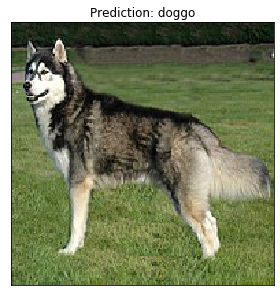

In [77]:
import urllib.request as req

with open('temp.png', 'wb') as f:
    link = 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Black-Magic-Big-Boy.jpg/220px-Black-Magic-Big-Boy.jpg'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png', model)

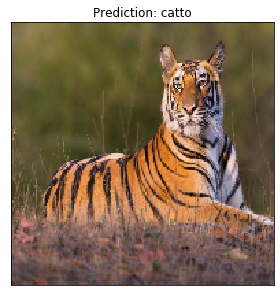

In [78]:
with open('temp.png', 'wb') as f:
    link = 'https://c402277.ssl.cf1.rackcdn.com/photos/18134/images/hero_small/Medium_WW226365.jpg?1574452099'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png', model)

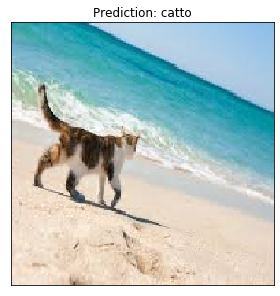

In [79]:
with open('temp.png', 'wb') as f:
    link = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRpIWoE-pL7ESUK_wZKxQV18HR0b9agMkkzqpOEtQx8c9M73pBV'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png', model)

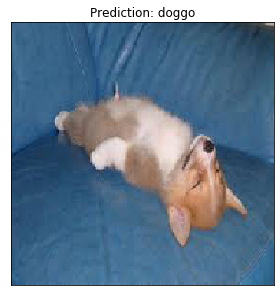

In [81]:
with open('temp.png', 'wb') as f:
    link = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSYrdxN4hcQ7ifM_LwoDAIzZraFEs9Zr7ge04_4COCrWEZBskjD'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png', model)

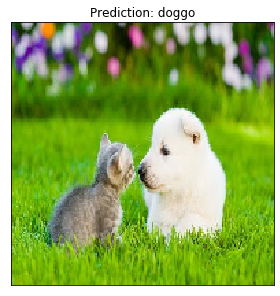

In [82]:
with open('temp.png', 'wb') as f:
    link = 'https://www.doktorn.com/sites/default/files/styles/galleryformatter_slide/public/shutterstock_339623711%20sommarfaror%20f%C3%B6r%20hund%20och%20katt%20djurens%20h%C3%A4lsa.jpg'
    f.write(req.urlopen(link).read())
    predictCatDog('temp.png', model)
